In [24]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import cast_feature_dtypes, pull_data, pull_projections
from modeling import split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import AGG_YEARS, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [25]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Casting feature dtypes for batting & pitching dataframes
batting_df = cast_feature_dtypes(batting_df)
pitching_df = cast_feature_dtypes(pitching_df)

# Filtering pitchers from batting_df, they should not be included in the batter model
batting_df = batting_df[batting_df["pos_type"] != "Pitcher"].copy()
# Dropping pos_type and primary_pos from pitching_df as they are redundant (every player is a pitcher)
pitching_df = pitching_df.drop(columns=["pos_type", "primary_pos"]).copy()

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with 0 future fantasy points (would not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

C:\Users\jorda\Documents\development\baseball_modeling\read_data.py:656: DtypeWarning: Columns (173) have mixed types. Specify dtype option on import or set low_memory=False.
C:\Users\jorda\Documents\development\baseball_modeling\read_data.py:657: DtypeWarning: Columns (170) have mixed types. Specify dtype option on import or set low_memory=False.


Loaded existing data files.


In [ ]:
# TODO: Place generate_prediction_intervals into modeling.py script
# TODO: Code cleanup/organization

# Pulling FantasyPros Projection Data

In [27]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

# Creating Batting Model

## Creating baseline batting predictions

In [28]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df, random_state=202404)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 270.278 | MAE: 209.690 | R^2: 0.606


In [29]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  ...  Age  fantasy_points
321   Miguel Cabrera                 1762.0  ...   28            1718
893     Alex Bregman                 1772.0  ...   24            1665
1363      Derrek Lee                  460.0  ...   29            1868
1501      Carlos Lee                 1628.0  ...   29            1466
1460   Lance Berkman                 1710.0  ...   31            1516
...              ...                    ...  ...  ...             ...
384        Matt Kemp                  262.0  ...   34              70
970      Jamie Burke                   40.0  ...   36             142
1434   Deven Marrero                  113.0  ...   26             337
1367    Tres Barrera                   48.0  ...   26             184
1409   Cam Gallagher                  111.0  ...   26             226

[1590 rows x 8 columns]

# Building Final Model

In [ ]:
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.02), np.log(0.08)),

    # leaf-based complexity control
    "max_leaves": hp.quniform("max_leaves", 8, 96, 1),

    "subsample": hp.uniform("subsample", 0.65, 0.95),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.65, 1.00),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(0.5), np.log(8.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-5), np.log(10.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(10.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(1.0)),
}

In [ ]:
from xgboost import XGBRegressor

def generate_prediction_intervals(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame | None,
    y_val: pd.Series | None,
    X_pred: pd.DataFrame,
    *,
    base_params: dict,
    n_bootstrap: int = 30,
    random_state: int = 62820,
    id_cols: list[str] | None = None,
    n_estimators: int = 5000,
    early_stopping_rounds: int = 50,
) -> pd.DataFrame:
    """
    Estimate prediction intervals via bootstrap-resampled leaf-based XGBoost models.

    Trains n_bootstrap models on random subsamples (with replacement) of X_train/y_train,
    each validated on X_val/y_val. Aggregates predictions across all models to produce
    percentile estimates and upside/downside metrics for draft prioritization.

    Parameters
    ----------
    X_train, y_train
        Training predictors and target (resampled with replacement in each iteration).
    X_val, y_val
        Optional validation set for early stopping. Pass None to disable early stopping.
    X_pred
        Feature frame to generate intervals for. Index and id_cols are preserved in output.
    base_params : dict
        XGBoost hyperparameters from tuning (e.g., best_params from tune_xgb).
        Should include leaf-based settings (grow_policy, max_leaves, learning_rate, etc.).
    n_bootstrap : int, default 30
        Number of bootstrap models to train. Higher = smoother tails, slower runtime.
    random_state : int, default 62820
        Base seed; each bootstrap uses seed + iteration index for reproducibility.
    id_cols : list[str] | None, default ["IDfg"]
        Columns to preserve from X_pred in the returned frame (player identifiers).
    n_estimators, early_stopping_rounds : int
        XGBoost training arguments.

    Returns
    -------
    pd.DataFrame
        Index matches X_pred. Columns:
          - pred_mean: ensemble mean prediction
          - pred_p10, pred_p50, pred_p90: 10th, 50th, 90th percentiles
          - pred_width_80: (p90 - p10); total prediction uncertainty
          - pred_upside: (p90 - mean); expected ceiling gain
          - pred_downside: (mean - p10); expected floor loss
          - implied_upside: upside / downside ratio; >1 = positively skewed (high-ceiling players)
          - plus any id_cols from X_pred

    Notes
    -----
    Use pred_upside to identify breakout candidates; use pred_downside to avoid busts.
    Players with high upside and low downside offer best risk/reward for draft.
    """
    id_cols = id_cols or ["IDfg"]

    def _drop_ids(df: pd.DataFrame) -> pd.DataFrame:
        return df.drop(columns=[c for c in id_cols if c in df.columns], errors="ignore")

    # Prepare feature matrices (drop id cols for training/inference)
    X_tr = _drop_ids(X_train).reset_index(drop=True)
    X_v = _drop_ids(X_val).reset_index(drop=True) if X_val is not None else None
    X_p = _drop_ids(X_pred).reset_index(drop=True)

    # Ensure y indexes align
    y_tr_full = y_train.reset_index(drop=True)
    y_v_full = y_val.reset_index(drop=True) if y_val is not None else None

    rng = np.random.default_rng(random_state)
    preds_list = []

    for b in range(n_bootstrap):
        # Bootstrap indices from training set
        idx = rng.choice(len(X_tr), size=len(X_tr), replace=True)

        # Merge base_params with fixed defaults (base_params takes precedence)
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "tree_method": "hist",
            "enable_categorical": True,
        }
        params.update(base_params or {})

        model = XGBRegressor(
            n_estimators=n_estimators,
            random_state=random_state + b,
            early_stopping_rounds=early_stopping_rounds,
            n_jobs=-1,
            **params,
        )

        if X_v is not None and y_v_full is not None and early_stopping_rounds:
            model.fit(
                X_tr.iloc[idx],
                y_tr_full.iloc[idx],
                eval_set=[(X_v, y_v_full)],
                verbose=False,
            )
        else:
            model.fit(
                X_tr.iloc[idx],
                y_tr_full.iloc[idx],
                verbose=False,
            )

        preds_list.append(model.predict(X_p))

    pred_mat = np.vstack(preds_list)  # shape: (n_bootstrap, n_rows_pred)

    out = pd.DataFrame(
        {
            "pred_mean": pred_mat.mean(axis=0),
            "pred_p10": np.percentile(pred_mat, 10, axis=0),
            "pred_p50": np.percentile(pred_mat, 50, axis=0),
            "pred_p90": np.percentile(pred_mat, 90, axis=0),
        },
        index=X_pred.index,
    )

    out["pred_width_80"] = out["pred_p90"] - out["pred_p10"]
    out["pred_upside"] = out["pred_p90"] - out["pred_mean"]
    out["pred_downside"] = out["pred_mean"] - out["pred_p10"]
    out["implied_upside"] = out["pred_upside"] / (out["pred_downside"] + 1e-9)

    # Prepend id columns from original X_pred when available
    id_present = [c for c in id_cols if c in X_pred.columns]
    if id_present:
        ids = X_pred[id_present].reset_index(drop=True)
        out = pd.concat([ids, out.reset_index(drop=True)], axis=1)
        out.index = X_pred.index

    return out


# Batting Predictions

In [ ]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=45,
    random_state=4202024,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_val=x_val,
    y_val=y_val,
    X_pred=batting_pred.drop(columns=['IDfg', 'Name', 'fantasy_points_future']),
    base_params=best_params,
    n_bootstrap=25,
    random_state=202404,
    id_cols=['IDfg'],
    n_estimators=3000,
    early_stopping_rounds=50,
)

100%|██████████| 45/45 [06:04<00:00,  8.10s/trial, best loss: 261.244934506402]  
Best Parameters: {'learning_rate': 0.020114006122092423, 'max_leaves': 17, 'grow_policy': 'lossguide', 'subsample': 0.7491540939252702, 'colsample_bytree': 0.8314565599696601, 'min_child_weight': 5.755365880724766, 'reg_lambda': 0.0001866689990767498, 'reg_alpha': 0.015153519414761023, 'gamma': 0.0001810308544588683}
[Best trial @ val] optimized=rmse | RMSE=261.245 | MAE=199.631 | ASYM=85648.275


In [33]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=42024,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 342
[Val] RMSE: 263.957 | MAE: 201.554 | R^2: 0.650 | ASYM: 87815.776
[Test] RMSE: 260.261 | MAE: 203.584 | R^2: 0.634 | ASYM: 83696.263


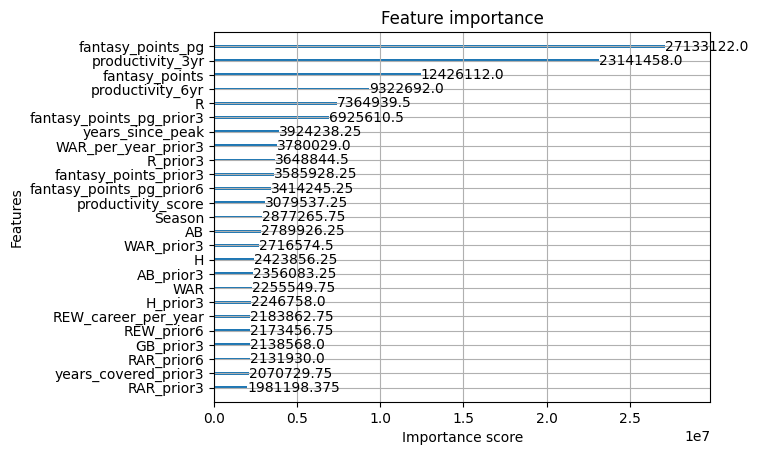

In [34]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [35]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  ...  Age  fantasy_points
321   Miguel Cabrera                 1762.0  ...   28            1718
893     Alex Bregman                 1772.0  ...   24            1665
1578      Joey Votto                  522.0  ...   29            1593
1115   J.D. Martinez                 1711.0  ...   29            1354
1460   Lance Berkman                 1710.0  ...   31            1516
...              ...                    ...  ...  ...             ...
1367    Tres Barrera                   48.0  ...   26             184
1439  Ehire Adrianza                  138.0  ...   29             429
892      Cole Tucker                  157.0  ...   22             243
481     Chance Sisco                  214.0  ...   24             373
1409   Cam Gallagher                  111.0  ...   26             226

[1590 rows x 8 columns]

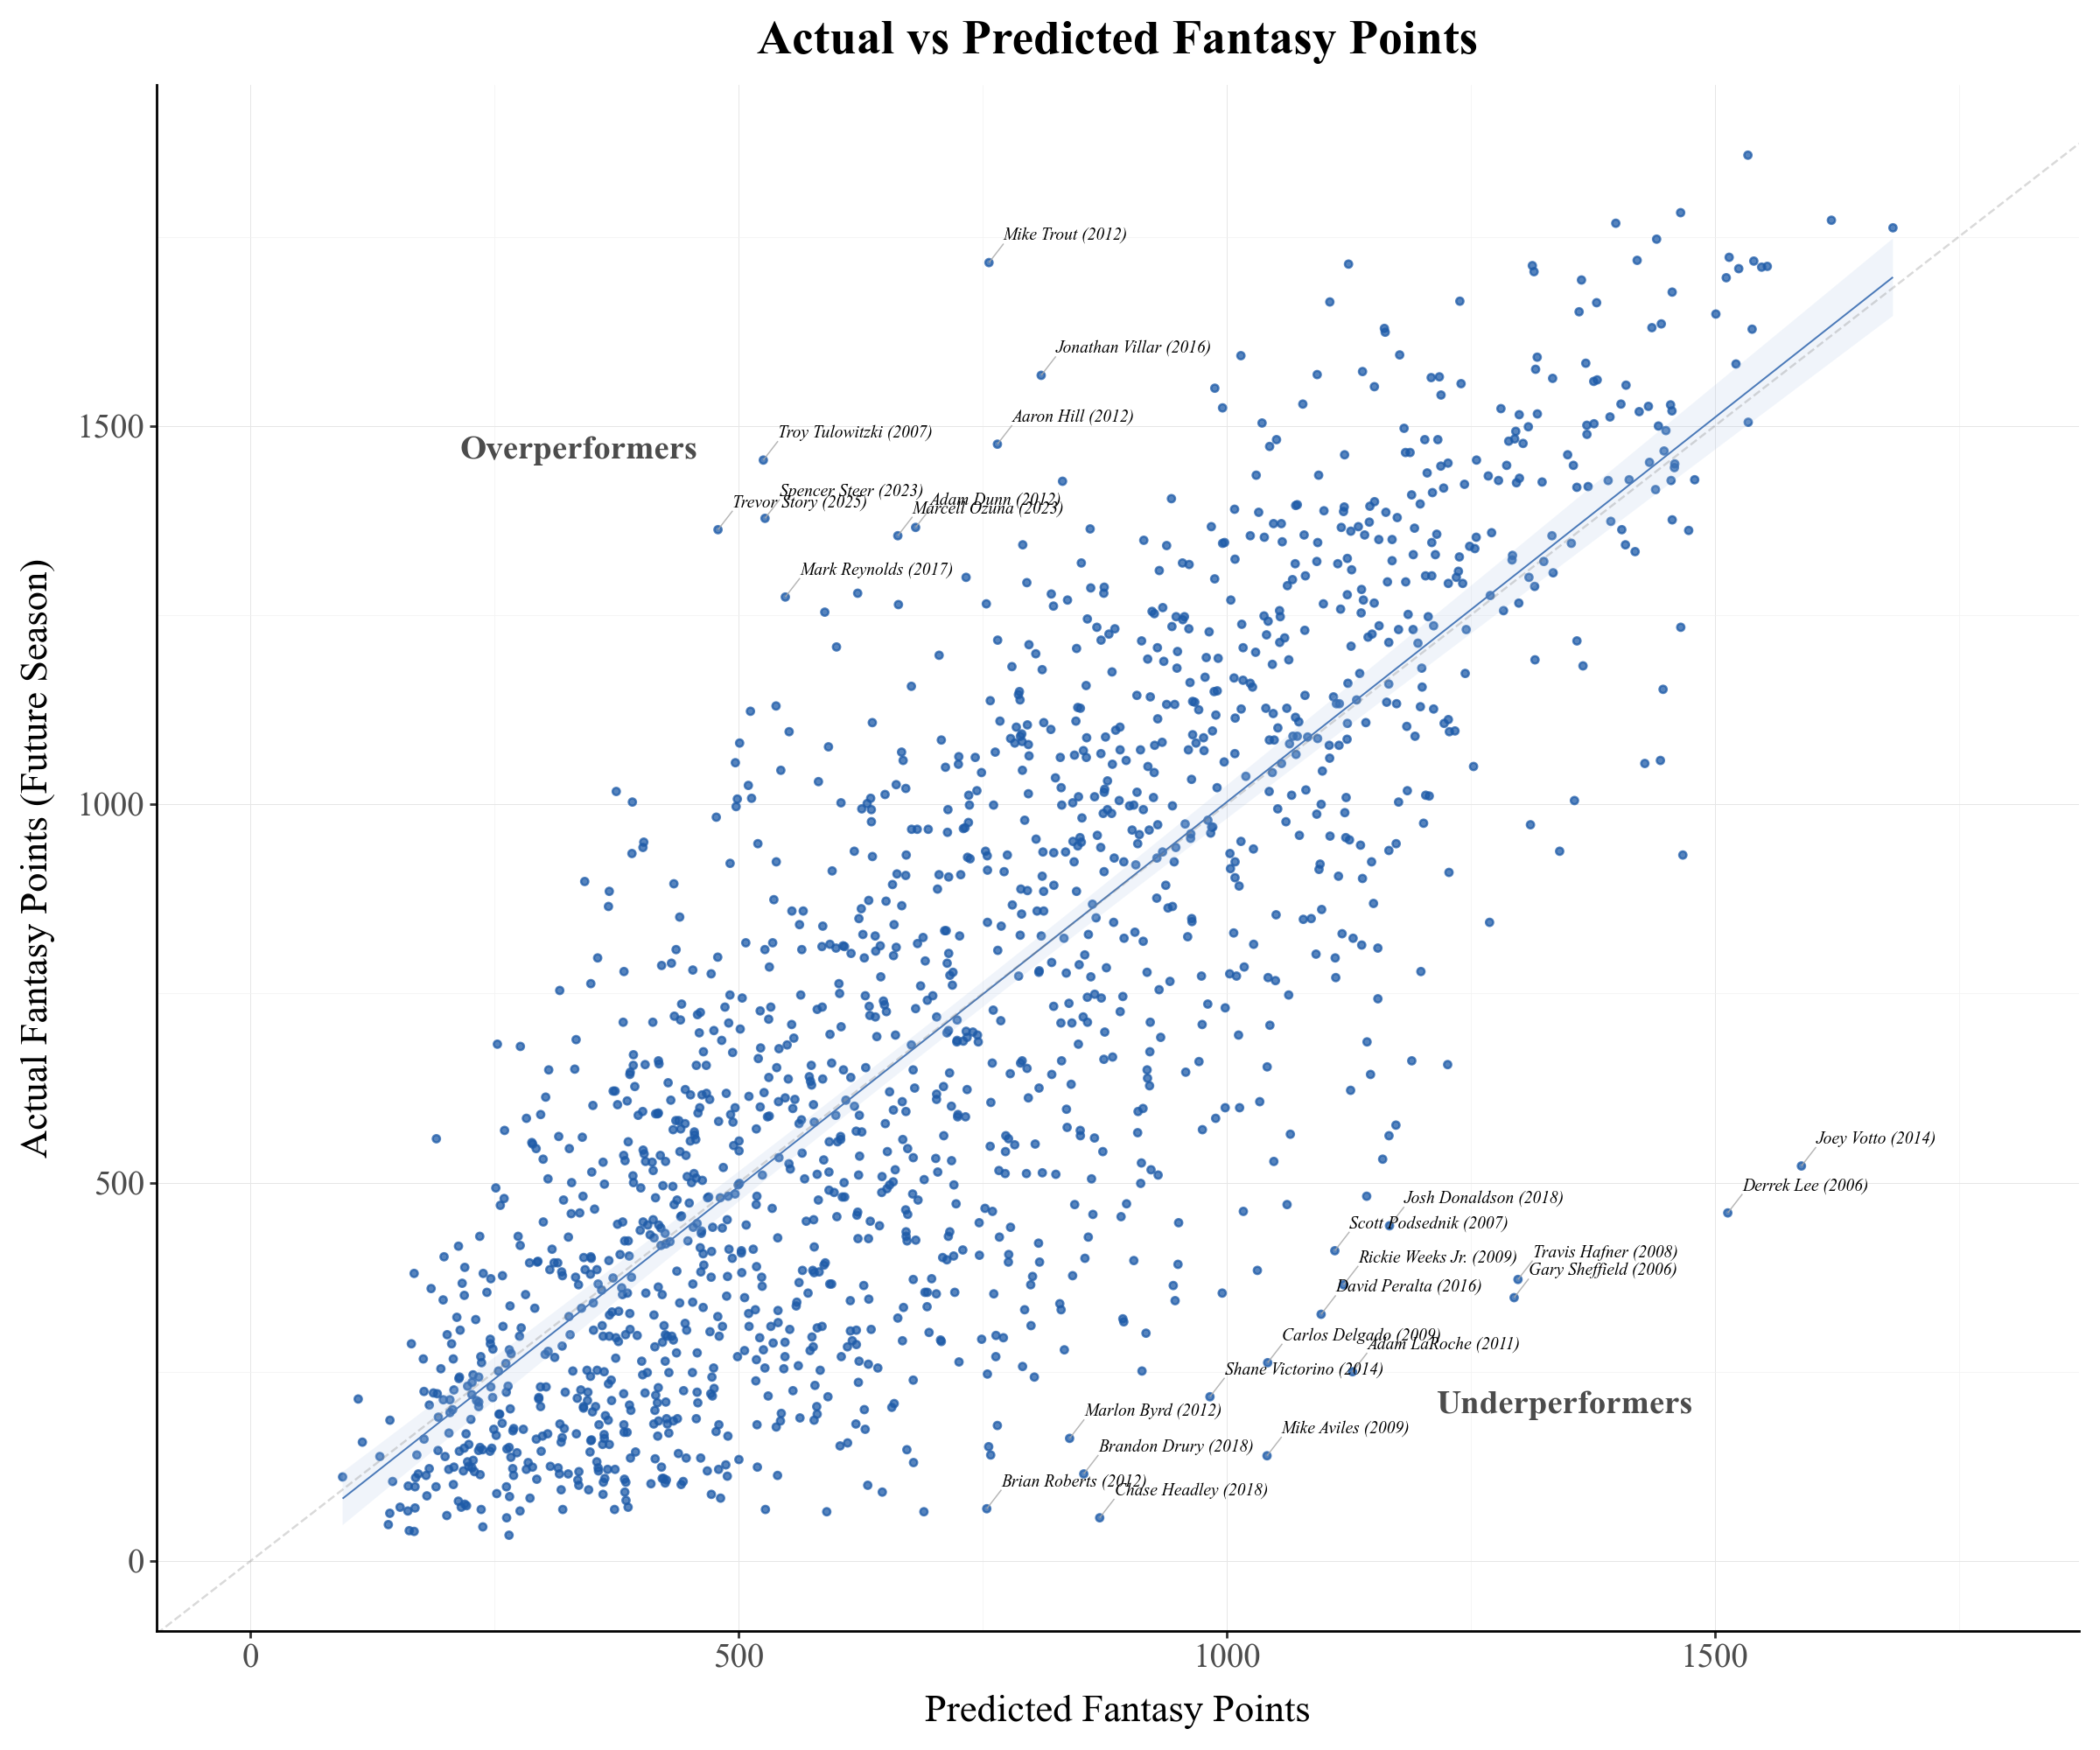

In [36]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

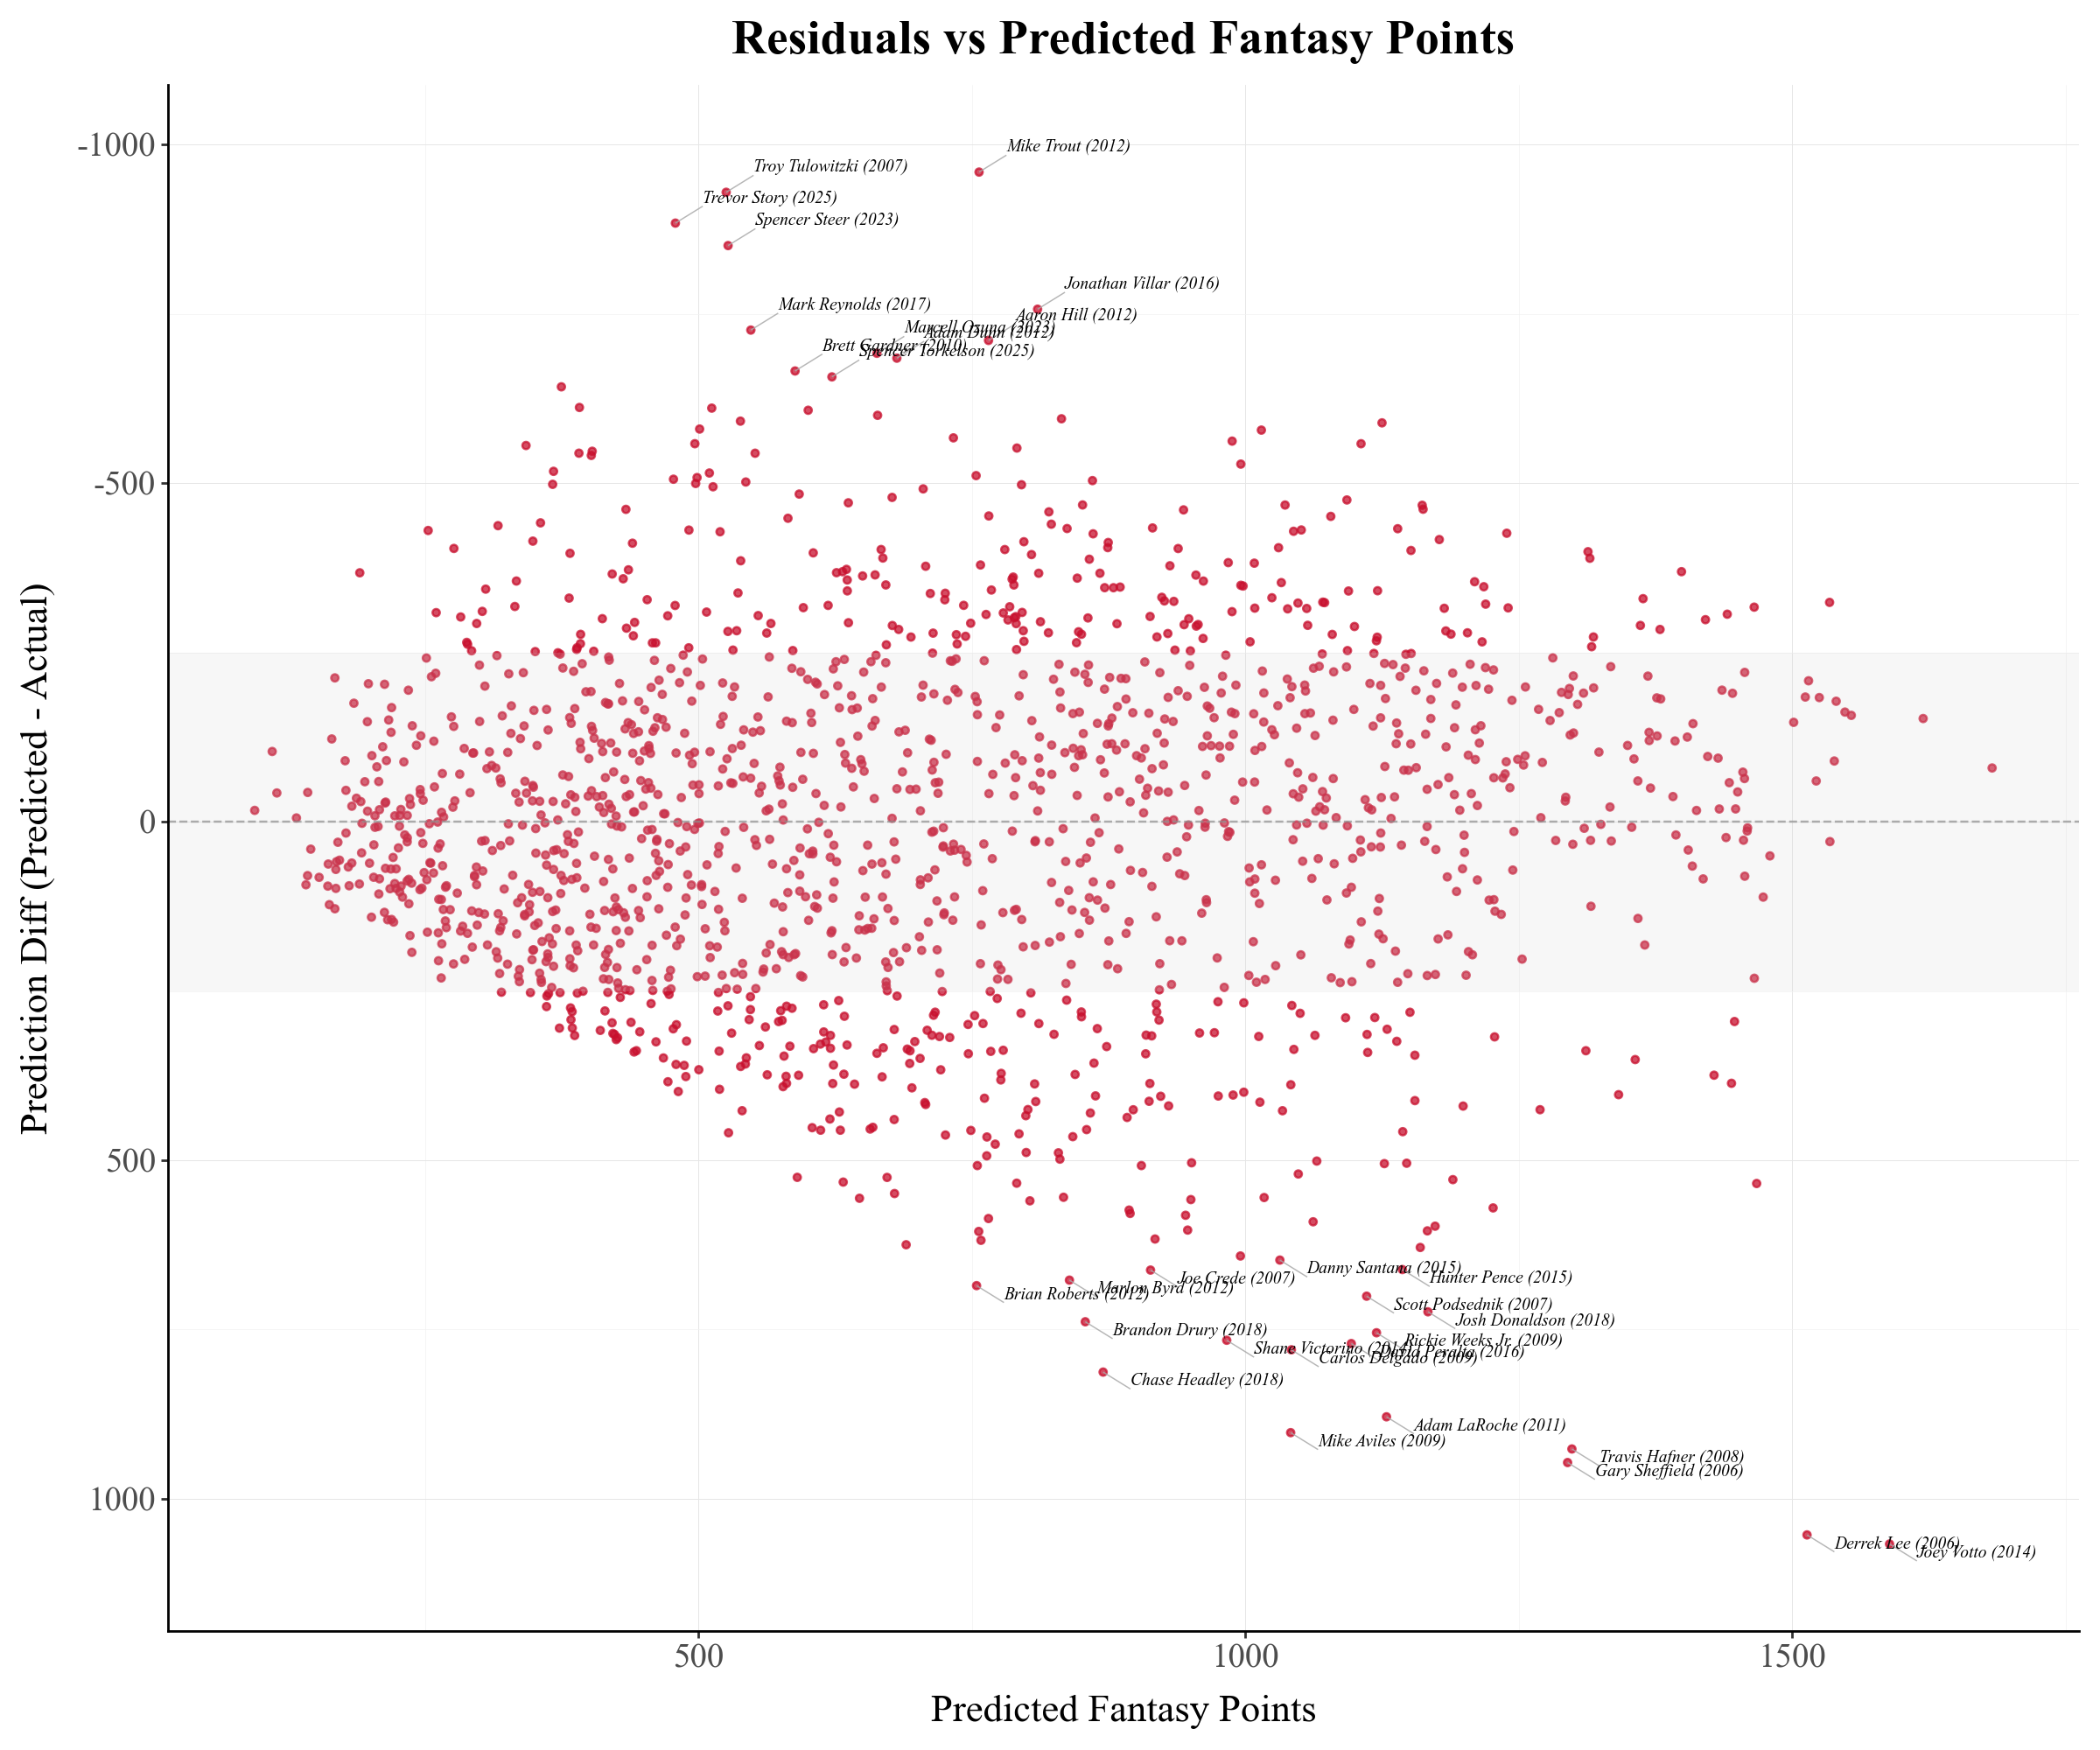

In [37]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

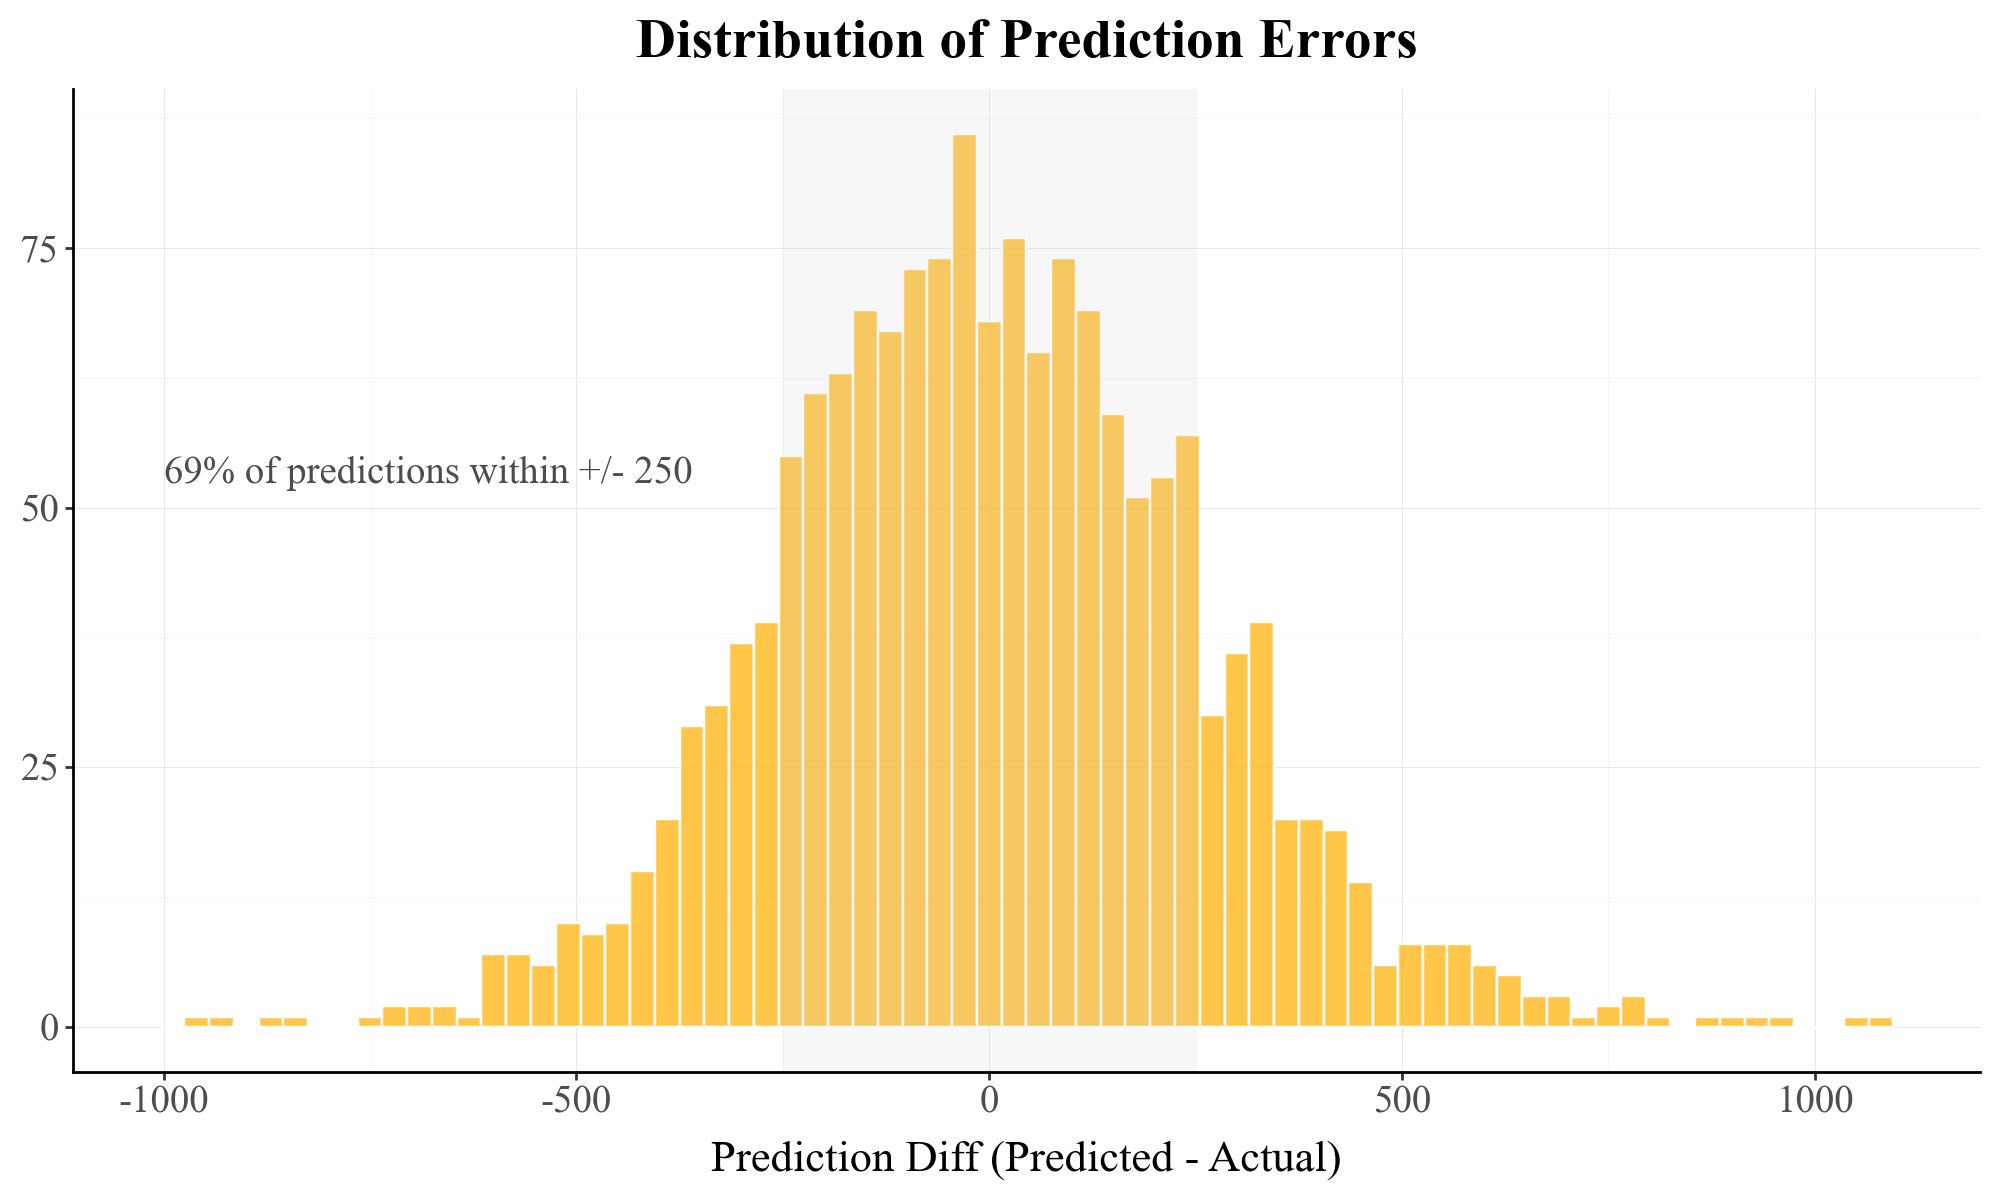

In [38]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

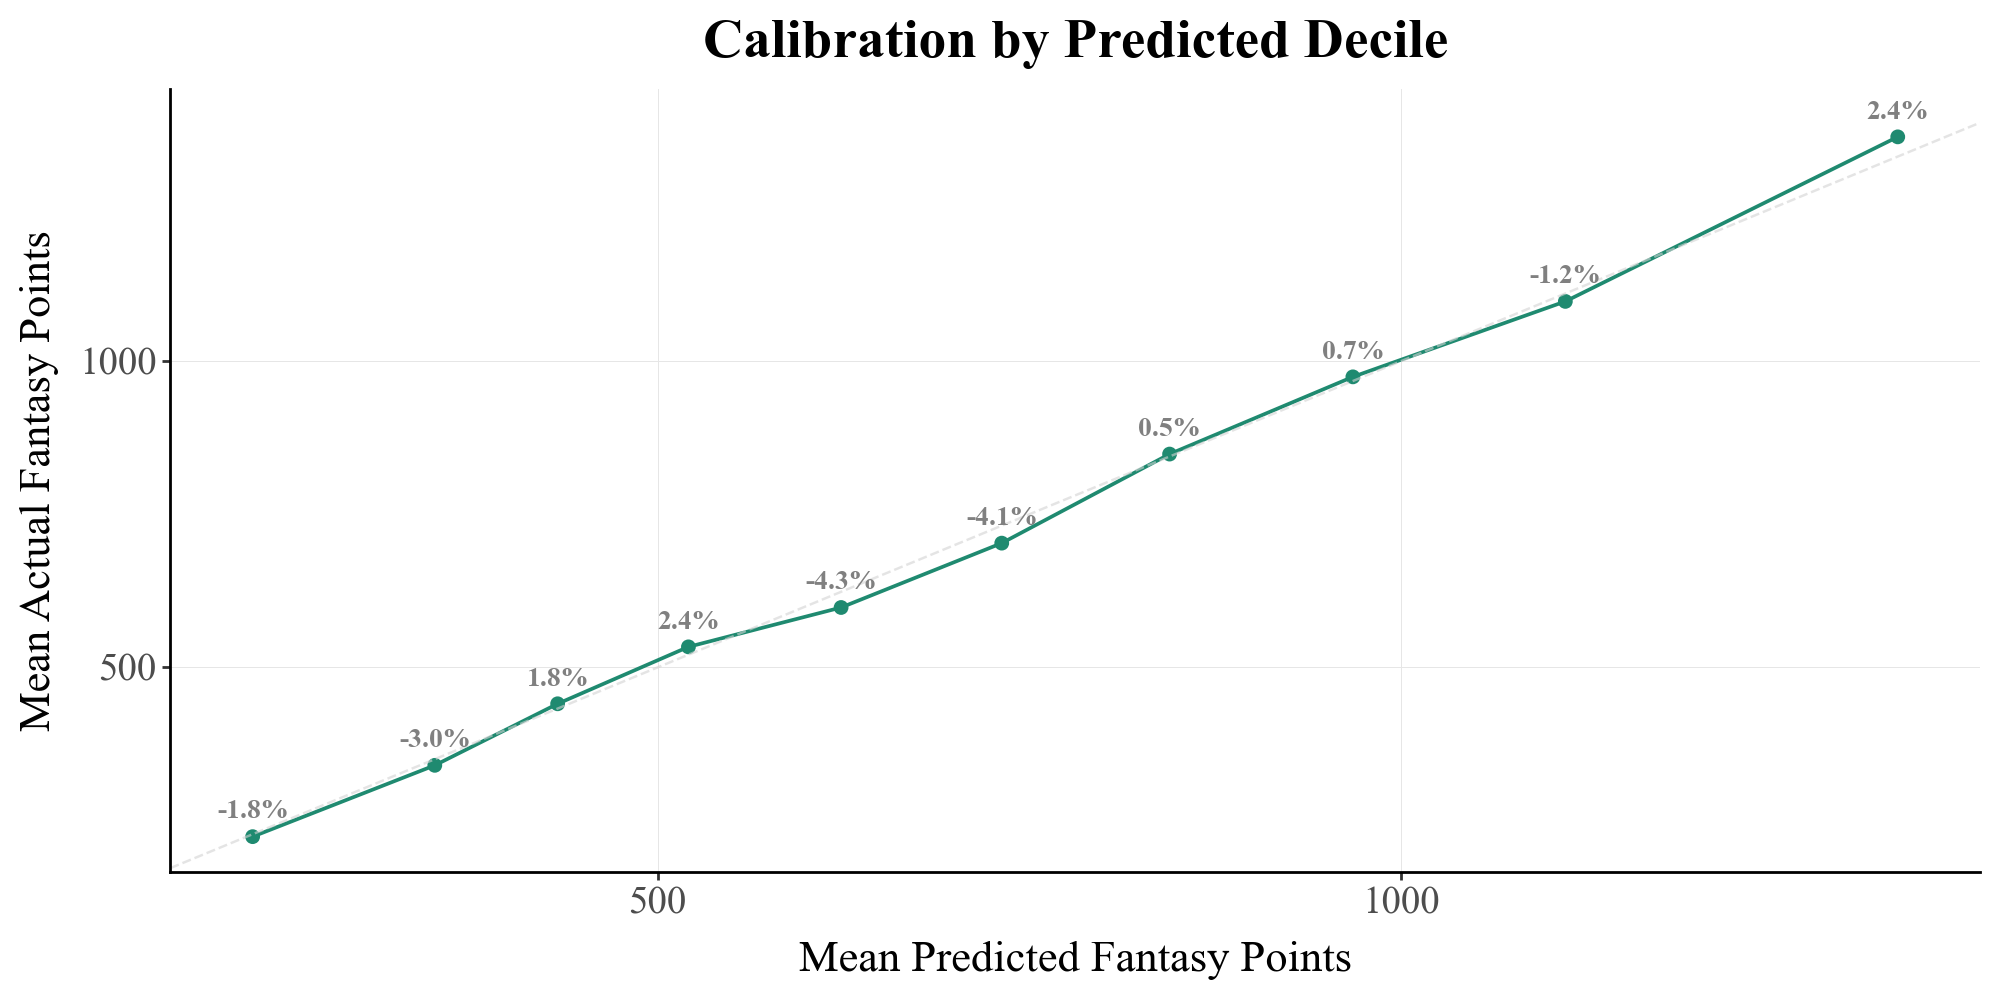

In [39]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [45]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df, random_state=202404)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 172.577 | MAE: 125.403 | R^2: 0.599


In [41]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  ...  Age  fantasy_points
531   Felix Hernandez                 1113.3  ...   26          1193.0
781   Clayton Kershaw                 1340.0  ...   24          1246.6
824   Felix Hernandez                 1165.6  ...   24          1319.6
29         Chris Sale                 1444.3  ...   27          1210.6
904  Justin Verlander                 1482.0  ...   35          1412.0
..                ...                    ...  ...  ...             ...
98       Scott Munter                   21.6  ...   25           124.6
850      Garrett Hill                   39.6  ...   26           234.3
986   Stefan Crichton                  136.0  ...   27           158.3
65      Mike Thompson                   24.6  ...   25           248.0
869      Kurt Birkins                  104.3  ...   25           148.0

[1525 rows x 8 columns]

# Pitching Predictions

In [ ]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=45,
    random_state=42020,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_val=x_val,
    y_val=y_val,
    X_pred=pitching_pred.drop(columns=['IDfg', 'Name', 'fantasy_points_future']),
    base_params=best_params,
    n_bootstrap=30,
    random_state=202404,
    id_cols=['IDfg'],
    n_estimators=3000,
    early_stopping_rounds=50,
)

100%|██████████| 45/45 [04:18<00:00,  5.74s/trial, best loss: 166.72875880060587]
Best Parameters: {'learning_rate': 0.06762255946355007, 'max_leaves': 22, 'grow_policy': 'lossguide', 'subsample': 0.8297012613015214, 'colsample_bytree': 0.7573431946165139, 'min_child_weight': 0.9254512382047718, 'reg_lambda': 1.1494105217253708e-05, 'reg_alpha': 0.06725817184880079, 'gamma': 0.003575224584321657}
[Best trial @ val] optimized=rmse | RMSE=166.729 | MAE=120.856 | ASYM=34139.073


In [50]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202022,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 152
[Val] RMSE: 169.422 | MAE: 123.031 | R^2: 0.635 | ASYM: 35569.322
[Test] RMSE: 170.612 | MAE: 123.799 | R^2: 0.608 | ASYM: 35447.019


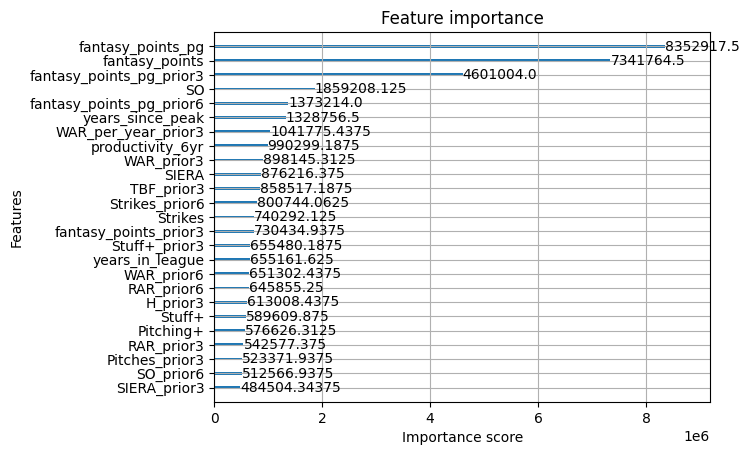

In [51]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [52]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  ...  Age  fantasy_points
824    Felix Hernandez                 1165.6  ...   24          1319.6
1428      Trevor Bauer                 1135.0  ...   27          1119.3
531    Felix Hernandez                 1113.3  ...   26          1193.0
781    Clayton Kershaw                 1340.0  ...   24          1246.6
904   Justin Verlander                 1482.0  ...   35          1412.0
...                ...                    ...  ...  ...             ...
869       Kurt Birkins                  104.3  ...   25           148.0
986    Stefan Crichton                  136.0  ...   27           158.3
857        Koda Glover                   75.3  ...   23            82.6
860    Anthony Ranaudo                   53.3  ...   25            39.3
939         Yoan Lopez                   66.6  ...   26           247.6

[1525 rows x 8 columns]

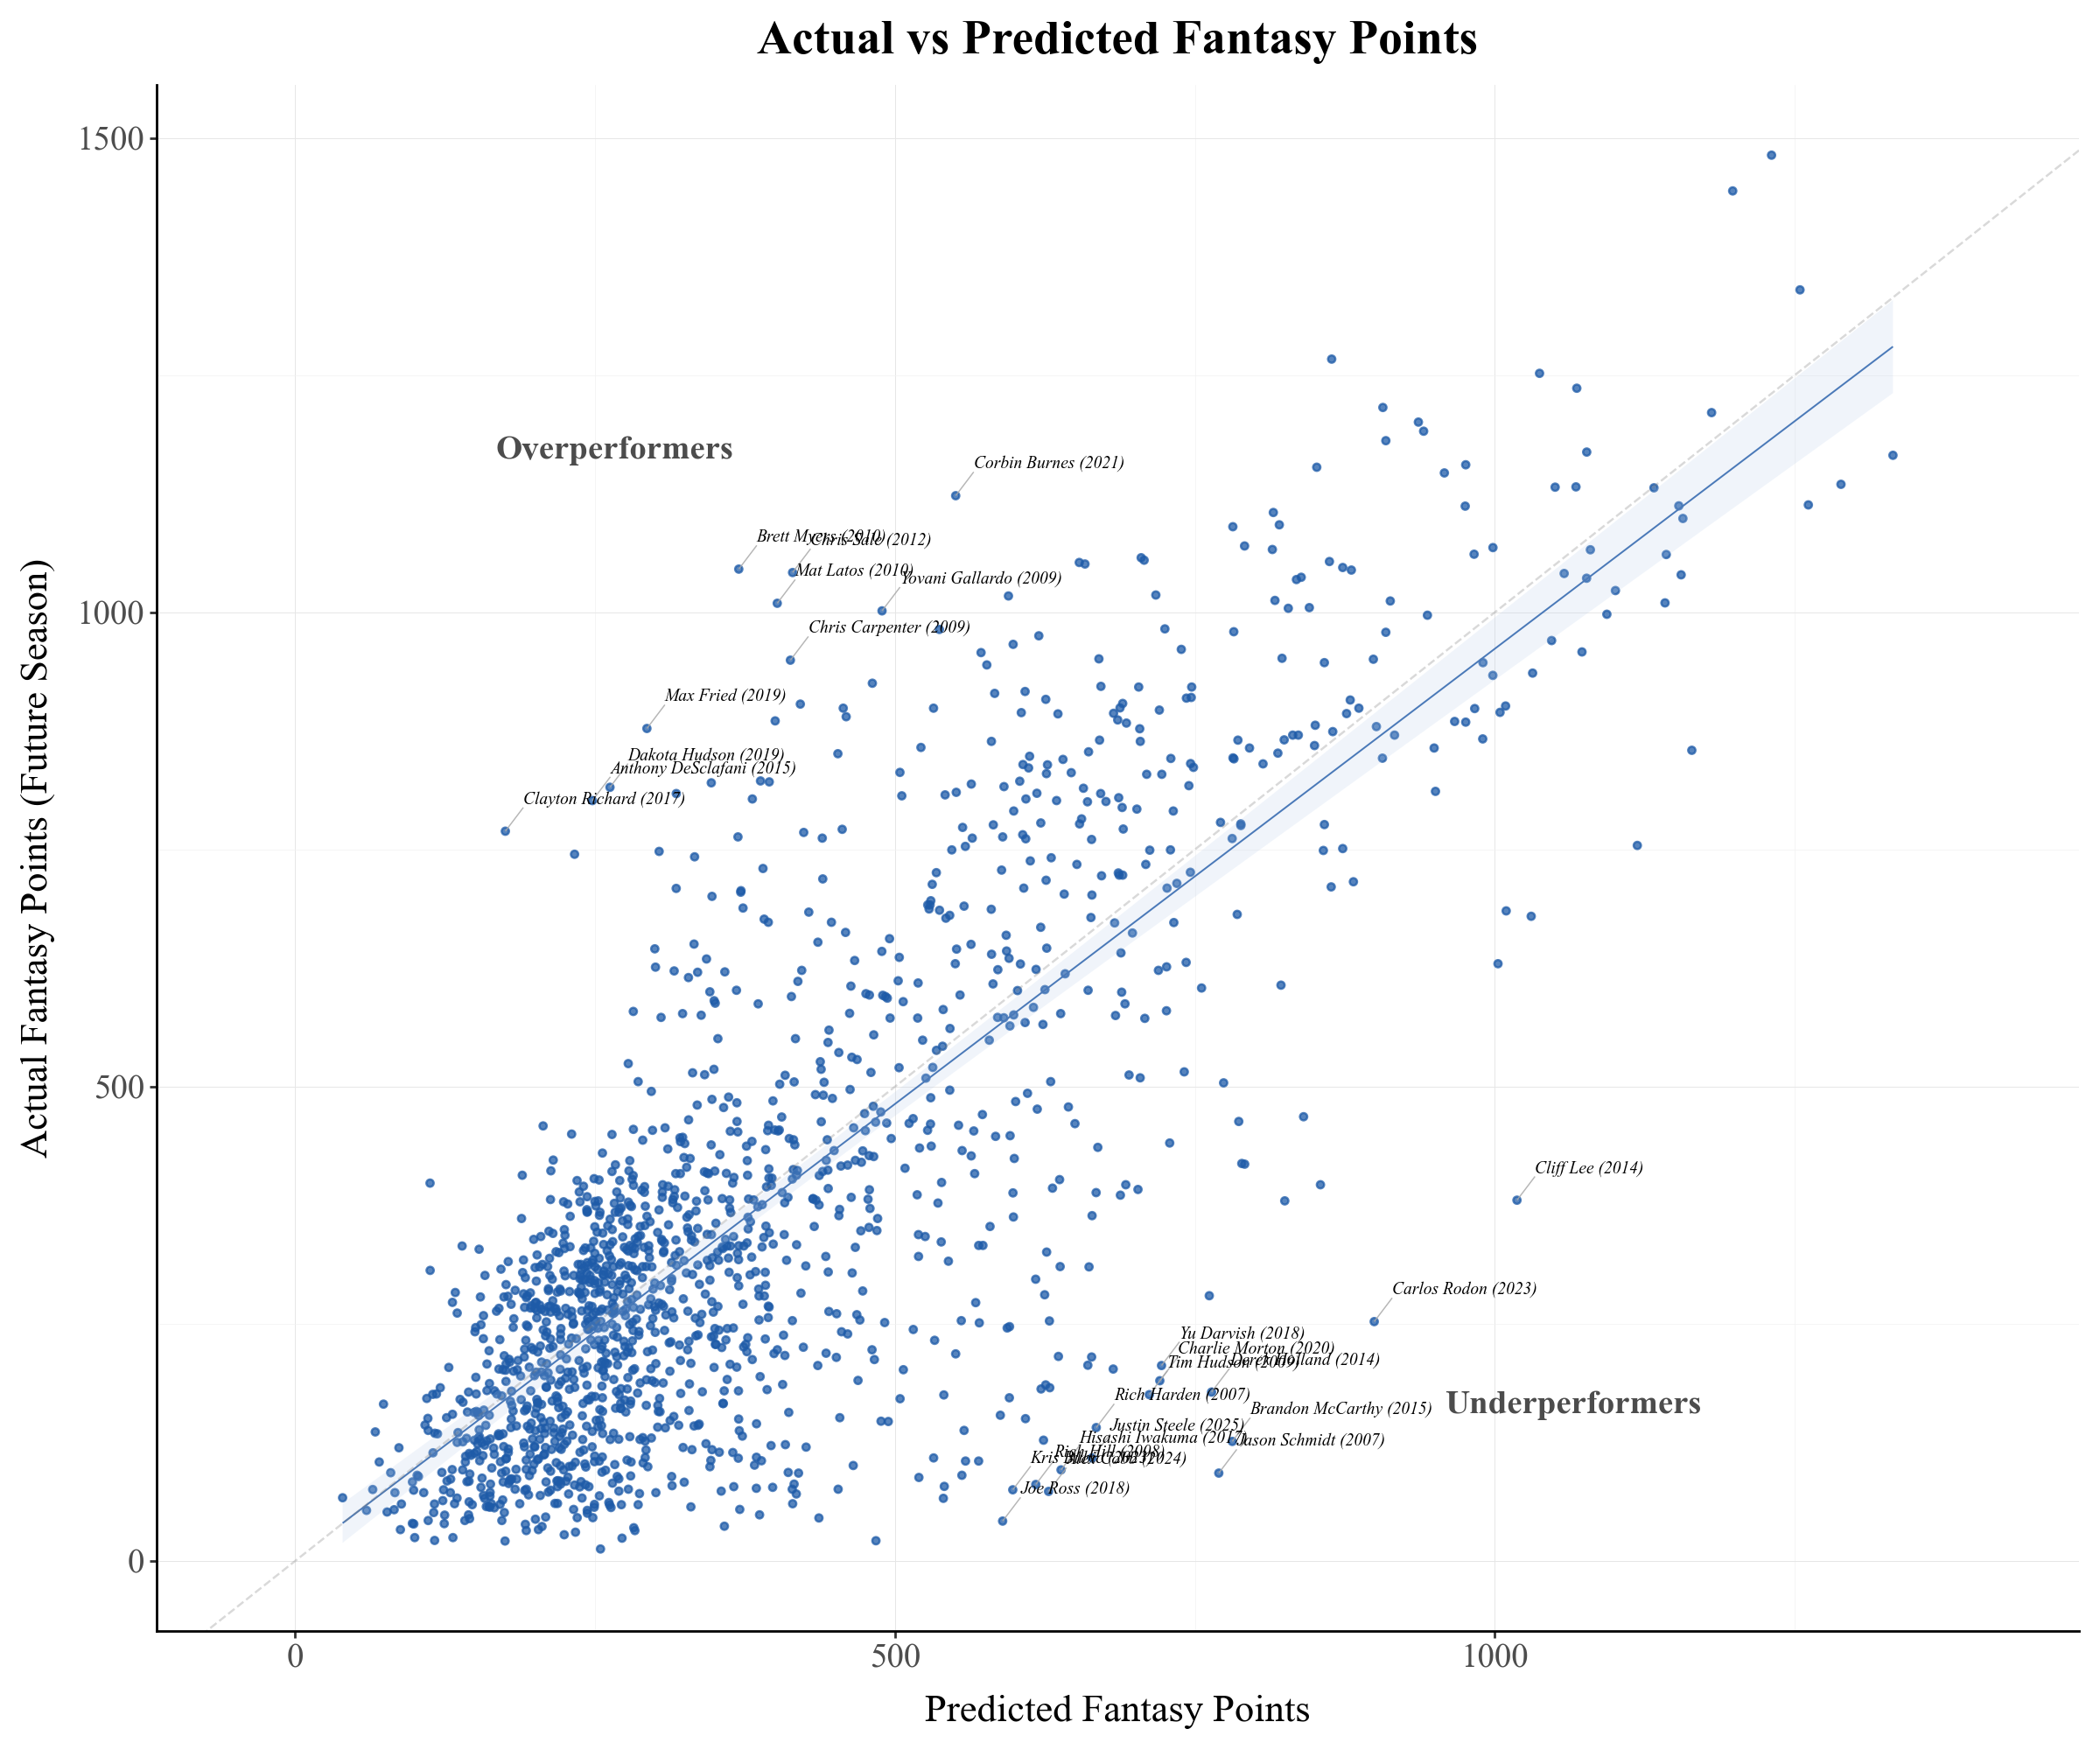

In [53]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

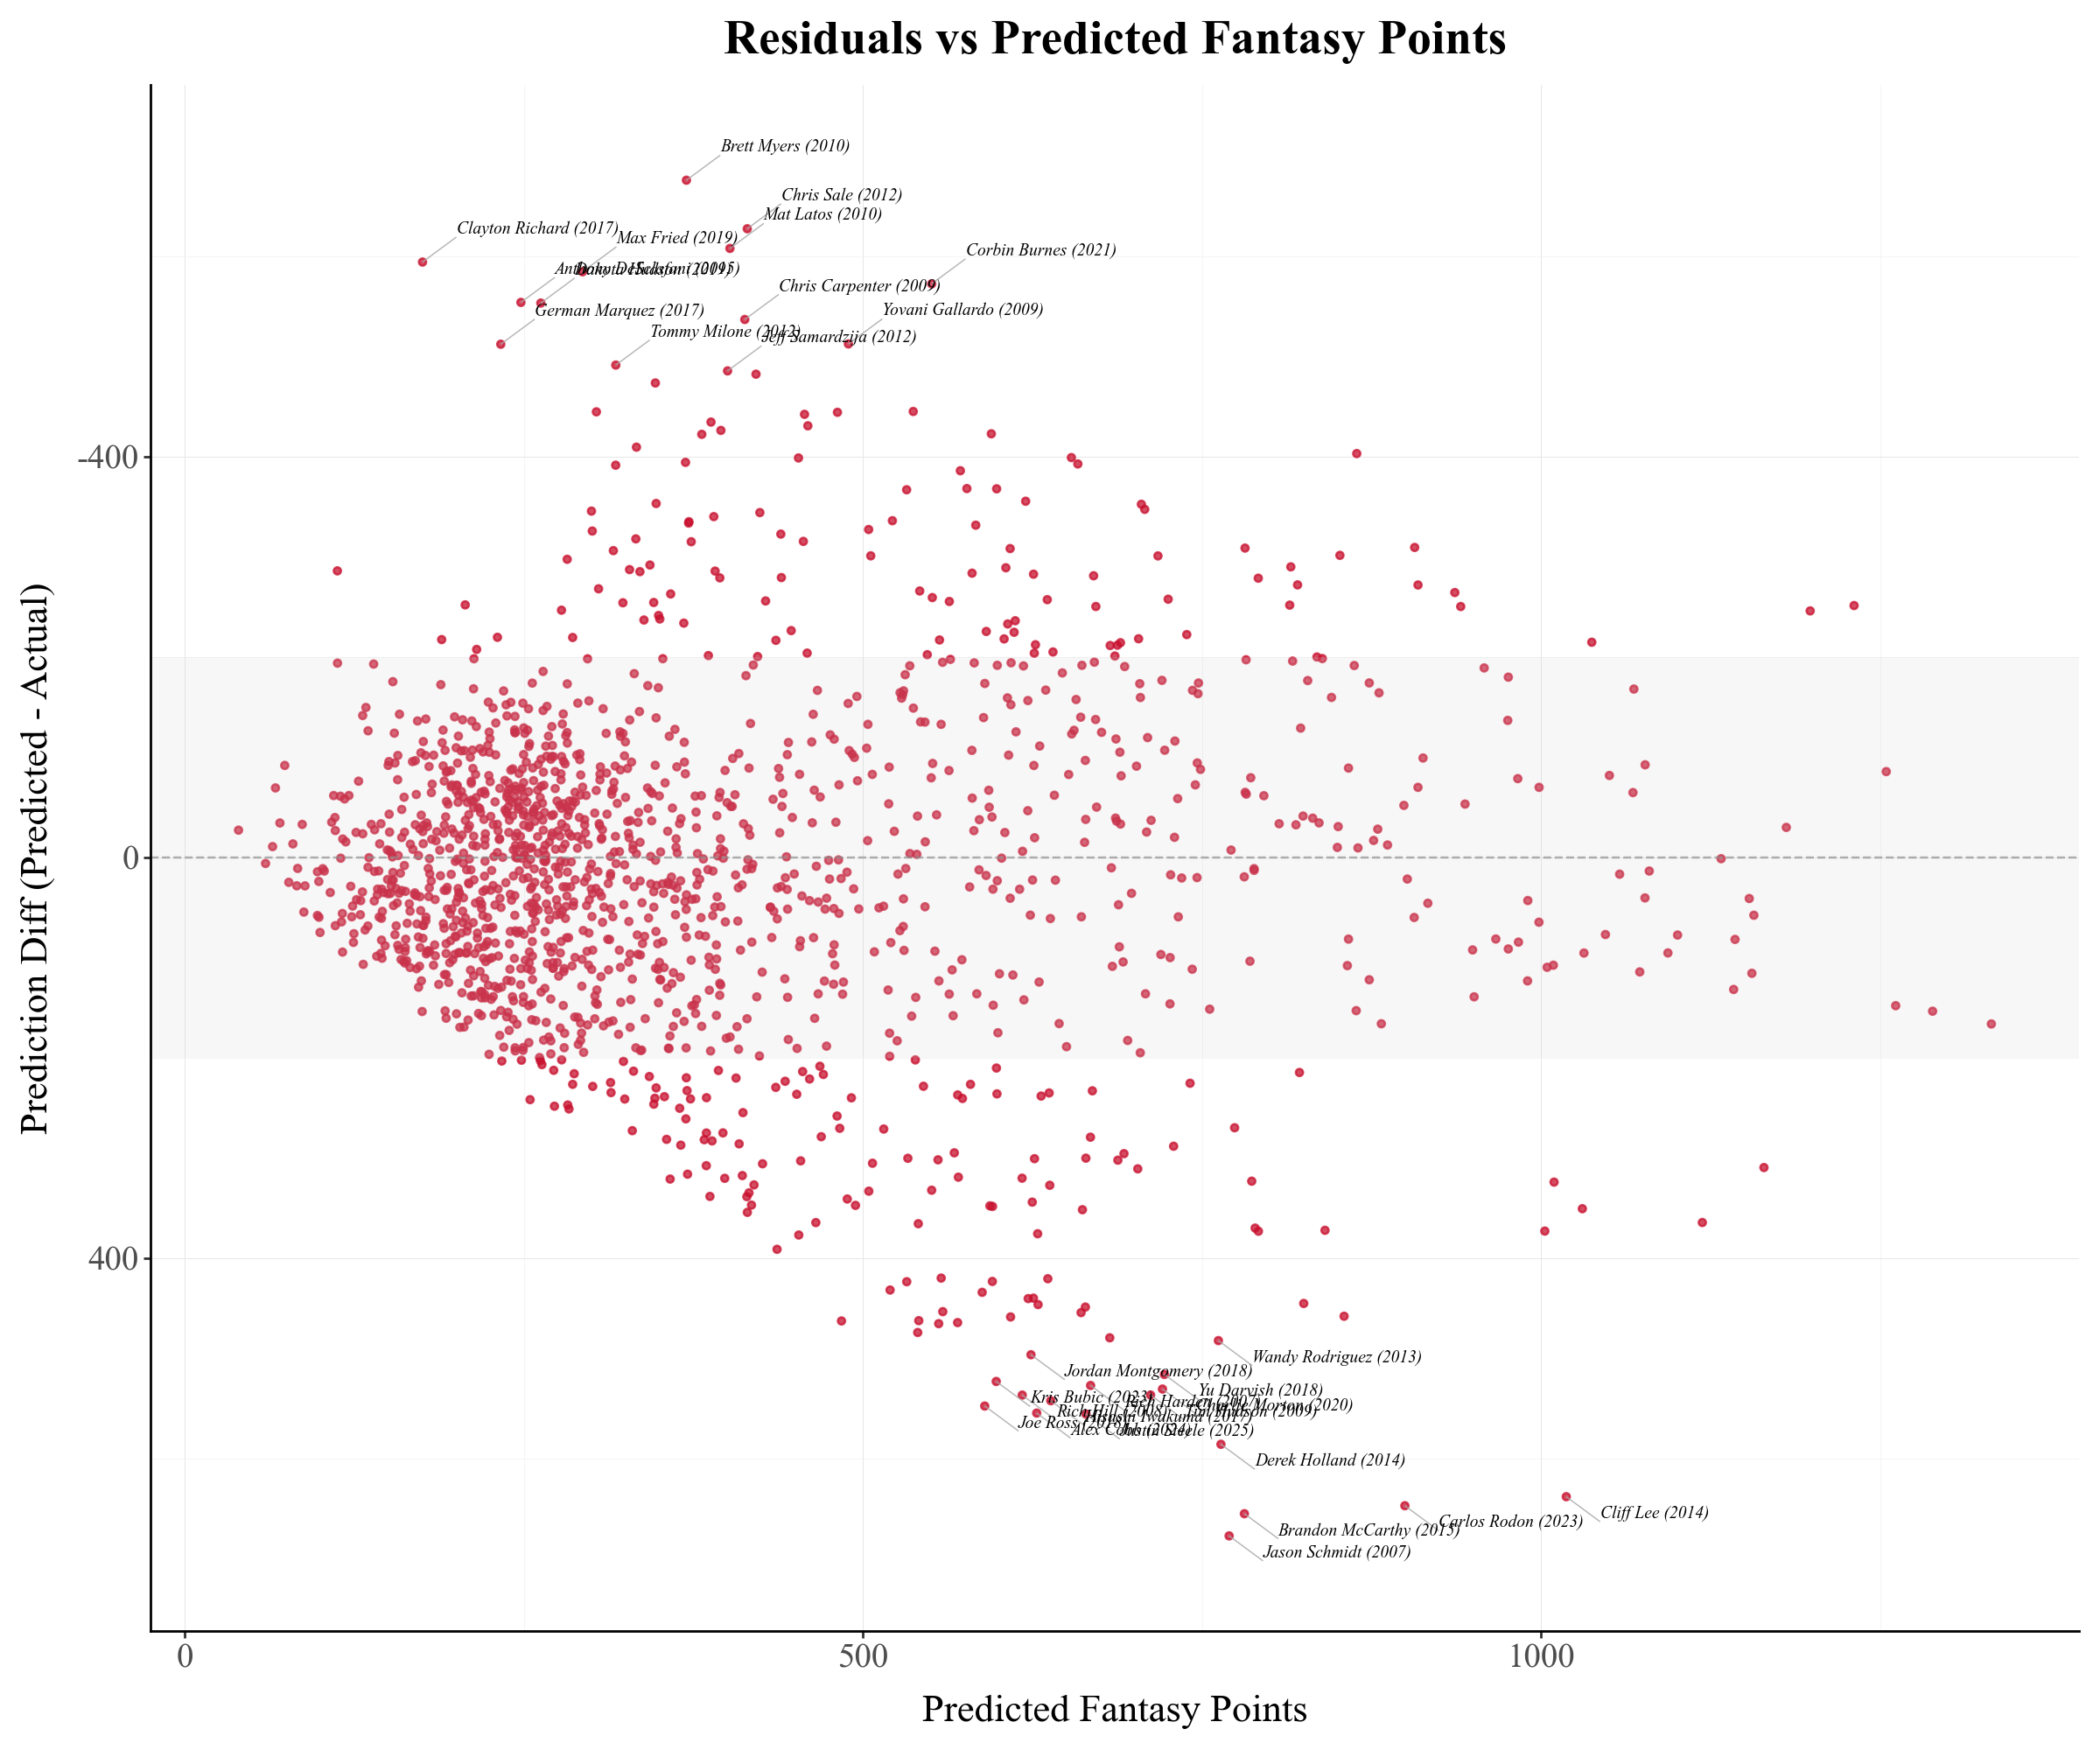

In [54]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

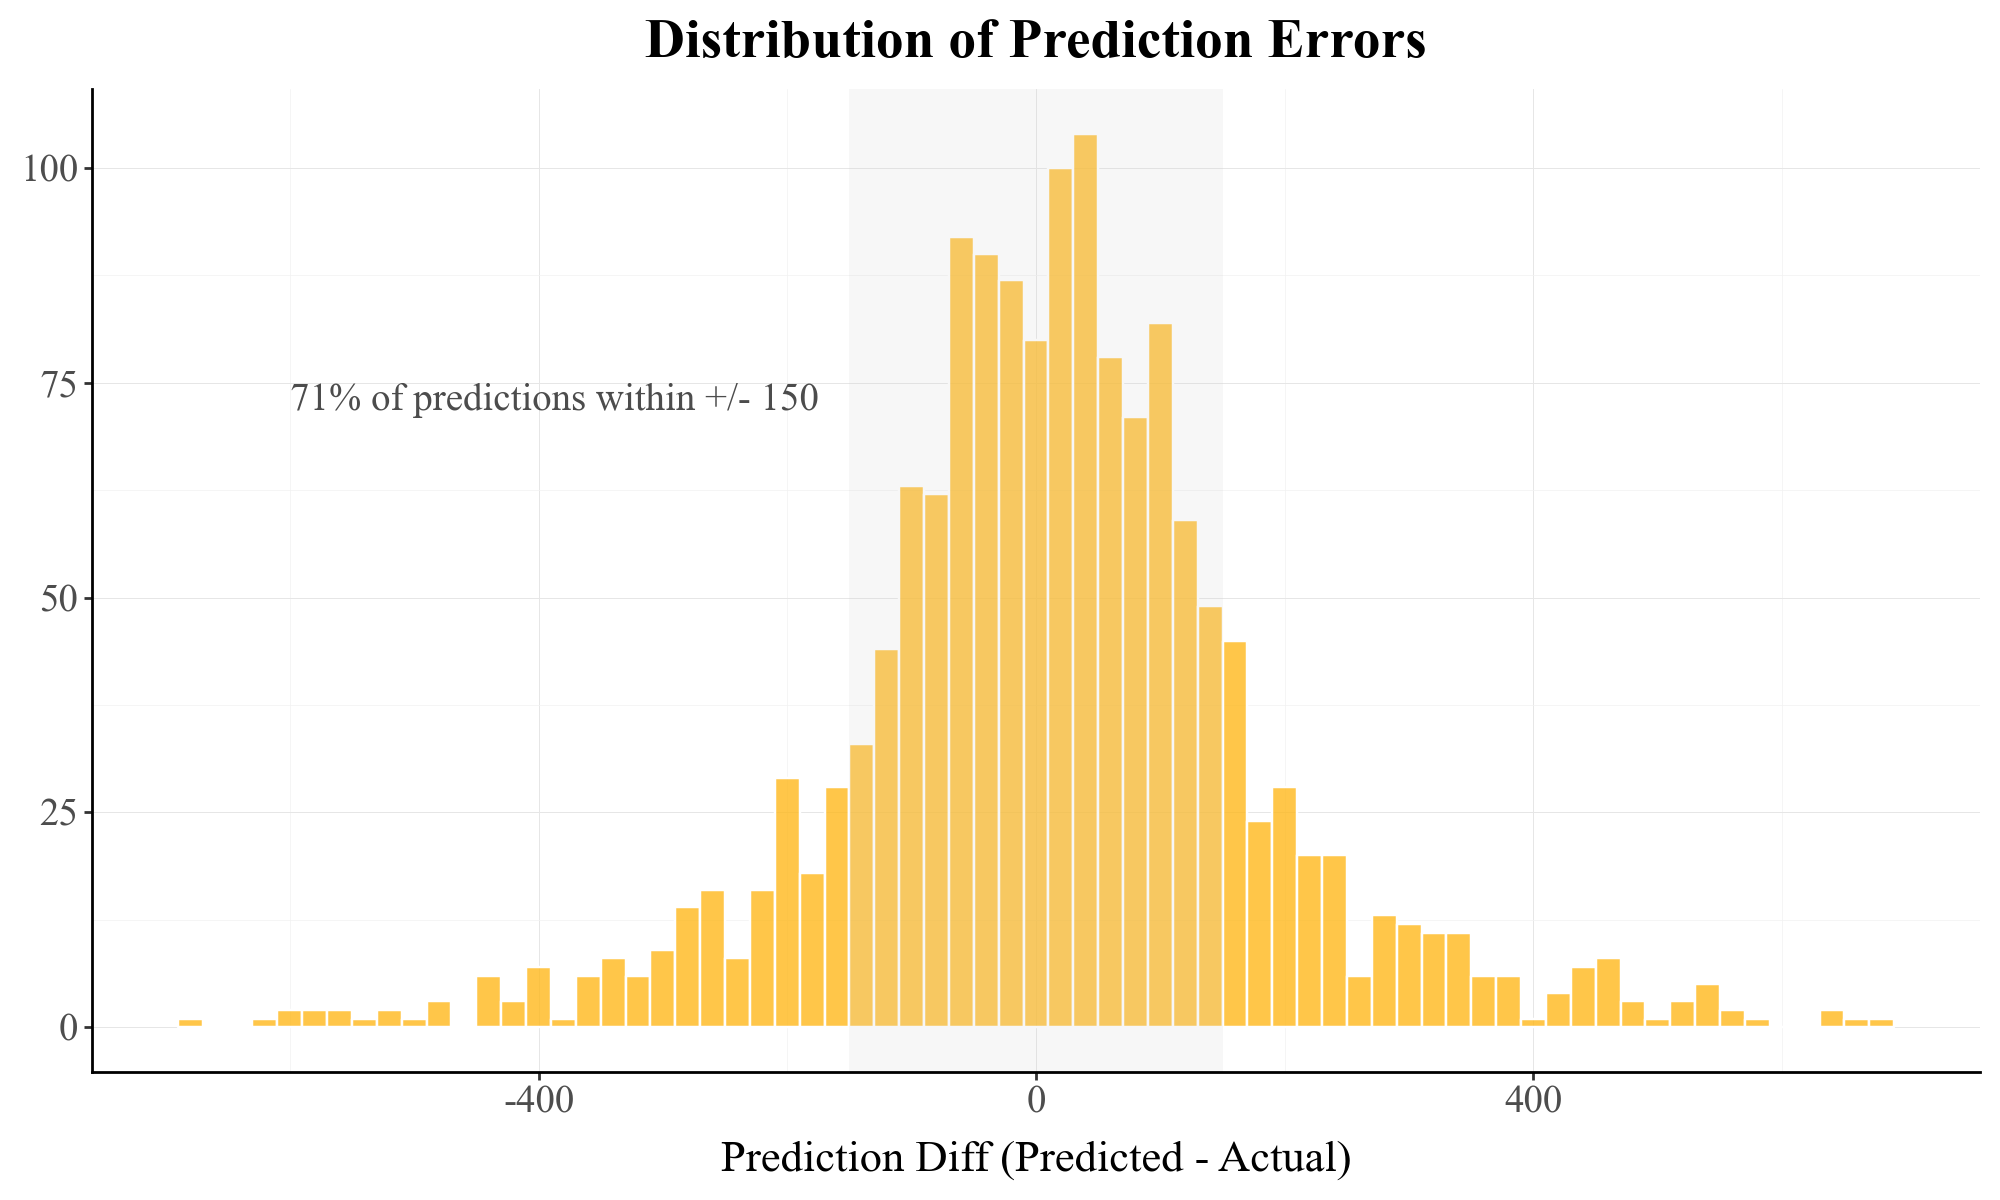

In [55]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=20,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

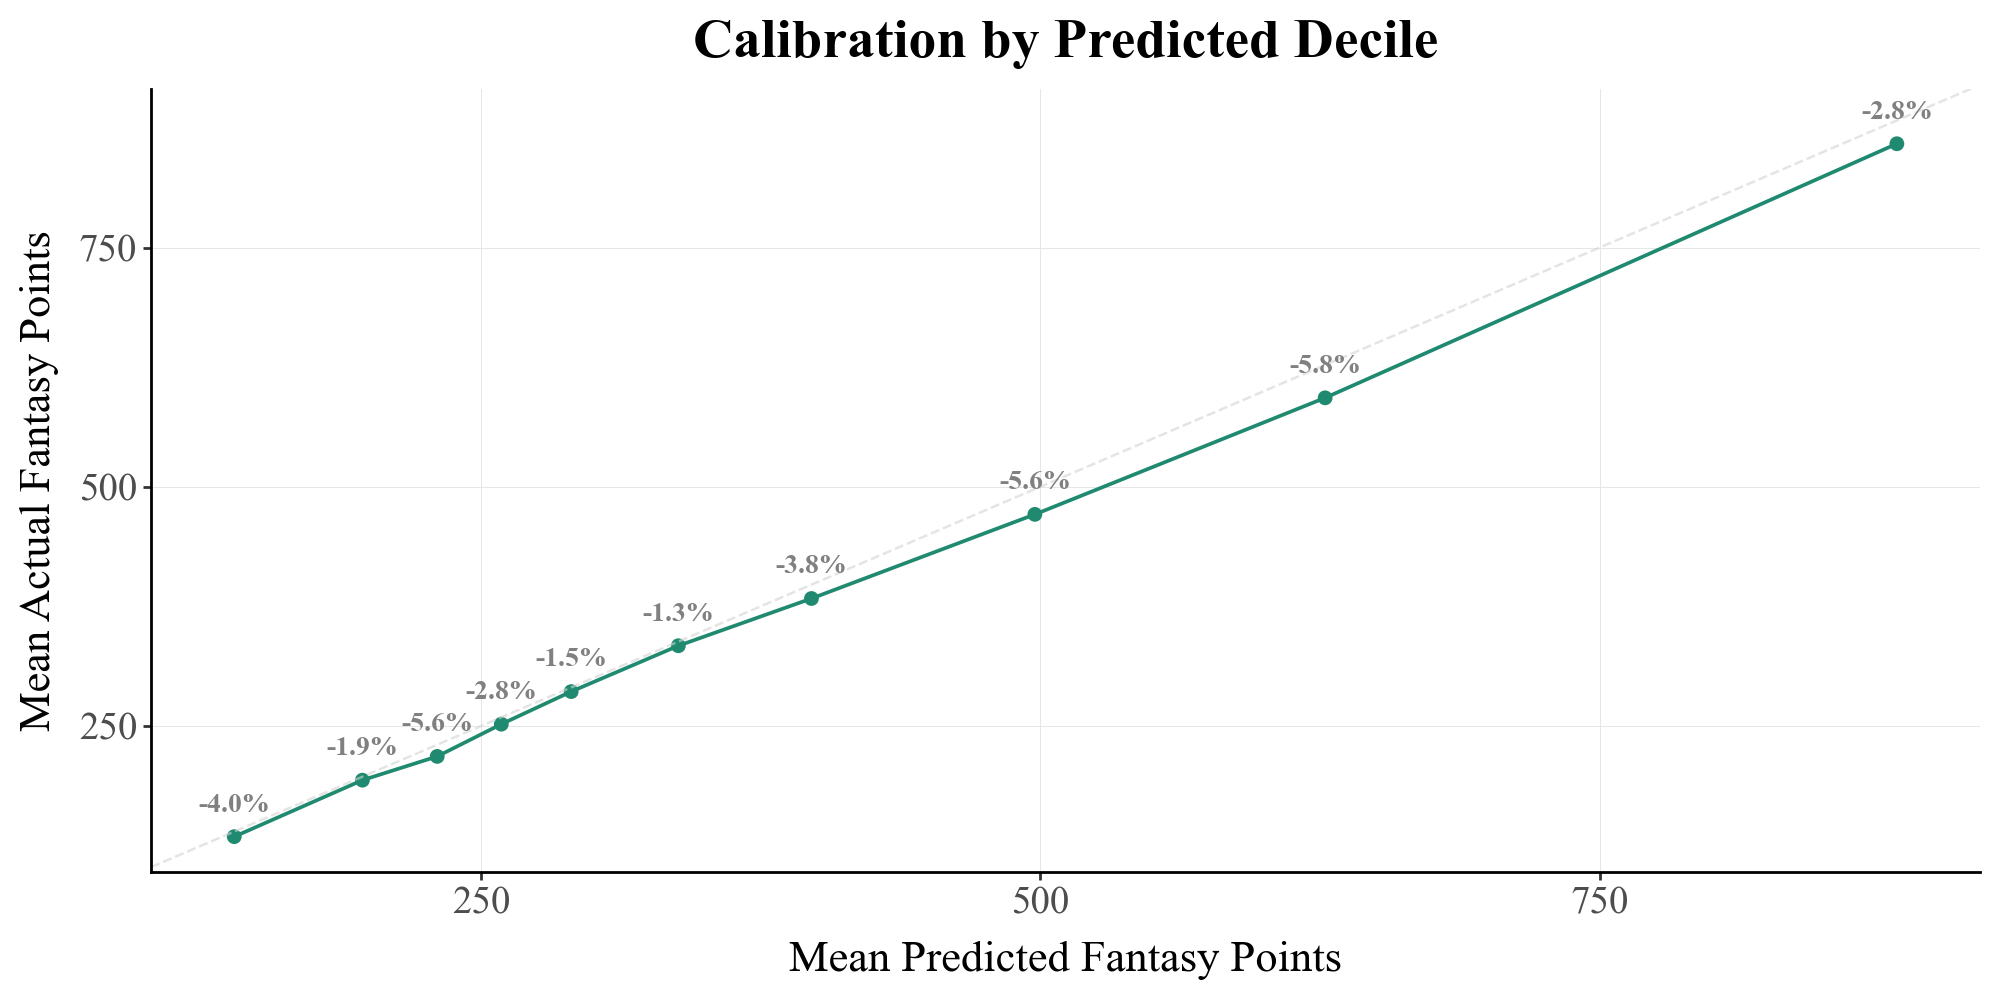

In [56]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [ ]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [62]:
display(batting_pred)

IDfg  Season  ... pred_asymmetry  pred_width_80
92   15640    2025  ...       0.710603     401.313721
203  19755    2025  ...       0.689728     363.650024
228  20123    2025  ...       0.535440     292.616577
366  25764    2025  ...       0.836075     200.989502
59   13510    2025  ...       0.807961     162.459595
..     ...     ...  ...            ...            ...
509  31661    2025  ...       1.300163      83.311676
486  30038    2025  ...       0.904126      86.141006
284  22209    2025  ...       1.040511      94.752434
485  30028    2025  ...       1.184641      81.530952
357  25434    2025  ...       1.507610      72.344940

[537 rows x 215 columns]

In [63]:
display(pitching_pred)

IDfg  Season  ... pred_asymmetry  pred_width_80
335  22267    2025  ...       1.269271      92.051880
24   10310    2025  ...       0.999059     162.858398
186  17995    2025  ...       0.936986     185.714478
195  18525    2025  ...       0.872678     152.530579
160  17295    2025  ...       1.013730     150.394043
..     ...     ...  ...            ...            ...
493  29628    2025  ...       0.649440      40.128532
549  31676    2025  ...       1.377706      84.795204
328  22200    2025  ...       1.318063      63.711037
543  31552    2025  ...       1.110327      55.372536
371  24203    2025  ...       1.052279      46.918297

[590 rows x 215 columns]

In [64]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [90]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name  ...  Team  Positions  projected_fantasy_points
450  13301.0  2025.0  Max Muncy  ...   LAD         3B                     884.0
451  13301.0  2025.0  Max Muncy  ...   ATH   2B,3B,SS                     665.0
452  29779.0  2025.0  Max Muncy  ...   LAD         3B                     884.0
453  29779.0  2025.0  Max Muncy  ...   ATH   2B,3B,SS                     665.0

[4 rows x 220 columns]

In [91]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season  ...    Positions  projected_fantasy_points
0        NaN     NaN  ...        3B,LF                      71.0
1    15640.0  2025.0  ...  LF,CF,RF,DH                    1748.0
2        NaN     NaN  ...     2B,3B,SS                      64.0
3        NaN     NaN  ...        1B,OF                     104.0
4    19844.0  2025.0  ...          NaN                       NaN
..       ...     ...  ...          ...                       ...
682  31562.0  2025.0  ...        LF,RF                     173.0
683  19392.0  2025.0  ...  3B,SS,LF,RF                     743.0
684  31347.0  2025.0  ...           SS                    1314.0
685  29766.0  2025.0  ...           2B                     220.0
686  19562.0  2025.0  ...          NaN                       NaN

[685 rows x 220 columns]

In [92]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [93]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name  ...  Team  Positions  projected_fantasy_points
0    31764.0  2025.0   A.J. Blubaugh  ...   NaN        NaN                       NaN
1        NaN     NaN             NaN  ...    KC          P                      83.0
2        NaN     NaN             NaN  ...   NYM         RP                     302.4
3        NaN     NaN             NaN  ...   ARI         RP                     204.7
4    23550.0  2025.0     Aaron Ashby  ...   MIL         RP                     311.7
..       ...     ...             ...  ...   ...        ...                       ...
891  20349.0  2025.0      Zack Kelly  ...   BOS      SP,RP                     247.5
892  15823.0  2025.0    Zack Littell  ...   NaN         SP                     707.3
893  10310.0  2025.0    Zack Wheeler  ...   PHI         SP                     729.6
894  25703.0  2025.0        Zak Kent  ...   TEX         RP                     192.4
895  31827.0  2025.0  Zebby Matthews  ...   MIN         SP                     600.2

[896 rows x 220 columns]

In [94]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points',
                               'pred_downside', 'pred_upside', 'pred_width_80', 'implied_upside']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [ ]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points',
                               'pred_downside', 'pred_upside', 'pred_width_80', 'implied_upside']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

# Finalizing Predictions & Creating Relative Positional Value Scores

In [98]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [99]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [100]:
# Creating final projected score, with 67% weight being placed on predictions and 33% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [101]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [102]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [103]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [104]:
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [ ]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)


In [106]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [69]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

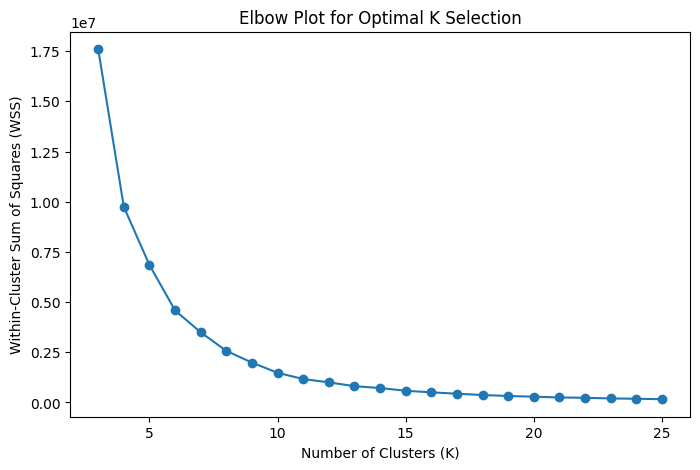

In [107]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [108]:
# Setting a K of 20 and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [ ]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [115]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)